# Rescheduling mit Lateness (Summe)
> Planunghorizont Tag 0: 2 Tage <br>
> Rescheduling des Tages 1

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics
import src.models.lp.lateness_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation
import time

In [5]:
max_time = 60*60*4 # 4h
max_time = 60*45 # 45 min

In [6]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 1, u_b_mmax= 0.92, shuffle = True)
df_jobs_arrivals

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [7]:
df_jobs = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_jobs

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


## I) Complete Scheduling

In [9]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_jssp_sum_absolute_lateness(df_jssp, df_jobs, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 11000

Solver-Informationen:
  Summe Absolute Lateness : 98.1146
  Solver-Status           : Optimal
  Anzahl Variablen        : 7486
  Anzahl Constraints      : 14516

Scheduling-Dauer: 246 Minuten und 5.71 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0.00,1246.644120,M0,0.00,29.0,29.00,-1217.64,1217.64
1,Job_000,1,0.00,1246.644120,M1,29.00,78.0,107.00,-1139.64,1139.64
2,Job_000,2,0.00,1246.644120,M2,107.00,9.0,116.00,-1130.64,1130.64
3,Job_000,3,0.00,1246.644120,M3,116.00,36.0,152.00,-1094.64,1094.64
4,Job_000,4,0.00,1246.644120,M4,152.00,49.0,201.00,-1045.64,1045.64
...,...,...,...,...,...,...,...,...,...,...
375,Job_037,8,2869.61,4573.882975,M4,4431.36,90.0,4521.36,-52.52,52.52
376,Job_033,7,2630.89,4698.109997,M3,4438.14,98.0,4536.14,-161.97,161.97
377,Job_037,9,2869.61,4573.882975,M7,4528.88,45.0,4573.88,-0.00,0.00
378,Job_033,8,2630.89,4698.109997,M9,4536.14,22.0,4558.14,-139.97,139.97


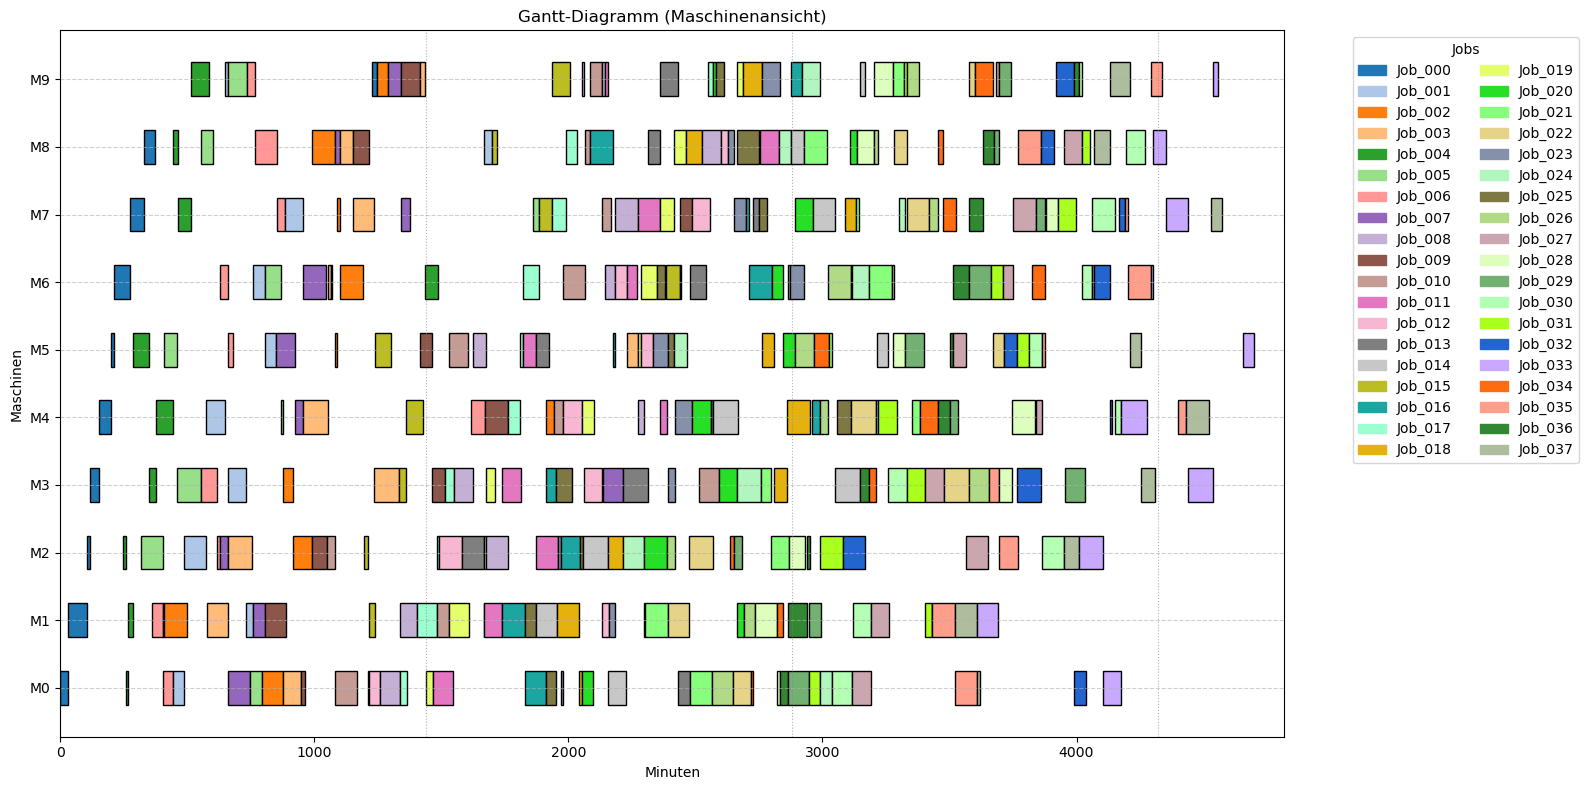

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [11]:
day_length = 1440

In [12]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [13]:
simulation = ProductionDaySimulation(df_plan, vc=0.25)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[02:05:27] Job_000 finished on M1 (after 96 minutes 28 seconds)
[02:05:27] Job_000 started on M2
[02:14:43] Job_000 finished on M2 (after 09 minutes 16 seconds)
[02:14:43] Job_000 started on M3
[02:45:09] Job_000 finished on M3 (after 30 minutes 26 seconds)
[02:45:09] Job_000 started on M4
[03:20:06] Job_000 finished on M4 (after 34 minutes 58 seconds)
[03:21:00] Job_000 started on M5
[03:36:07] Job_000 finished on M5 (after 15 minutes 07 seconds)
[03:36:07] Job_000 started on M6
[04:06:36] Job_004 started on M2
[04:25:46] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:25:46] Job_004 started on M0
[04:30:59] Job_004 finished on M0 (after 05 minutes 13 seconds)
[04:30:59] Job_004 started on M1
[04:59:34] Job_004 finished on M1 (after 28 minutes 35 seconds)
[04:59:34] Job_004 started on M5
[05:08:20] Job_000 finished on M6 (after 92 minutes 13 second

In [14]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_003,7,207.97,M3,1236.74,98.0
1,Job_009,5,781.95,M9,1339.64,76.0
2,Job_017,1,1324.04,M1,1405.28,78.0
3,Job_003,8,207.97,M9,1415.64,22.0
4,Job_009,6,781.95,M5,1415.64,47.0
...,...,...,...,...,...,...
285,Job_037,8,2869.61,M4,4431.36,90.0
286,Job_033,7,2630.89,M3,4438.14,98.0
287,Job_037,9,2869.61,M7,4528.88,45.0
288,Job_033,8,2630.89,M9,4536.14,22.0


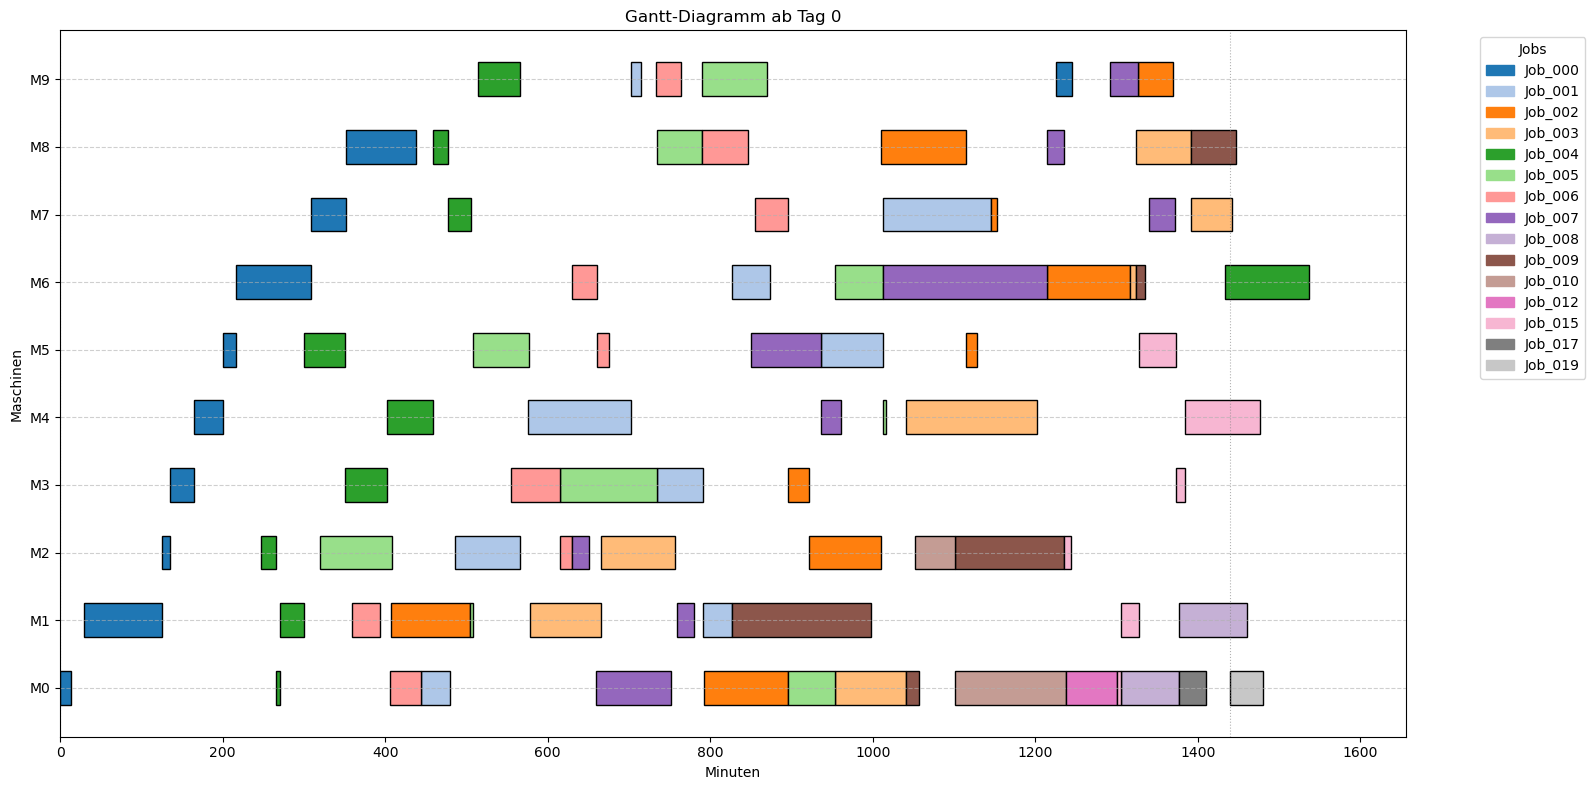

In [15]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [16]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_001,9,88.05,1697.641143,M8,1667.64,30.0,1697.64,-0.00,0.00
1,Job_002,9,152.78,1945.422685,M4,1912.42,33.0,1945.42,0.00,0.00
2,Job_003,7,207.97,2275.189997,M3,1236.74,98.0,1334.74,-940.45,940.45
3,Job_003,8,207.97,2275.189997,M9,1415.64,22.0,1437.64,-837.55,837.55
4,Job_003,9,207.97,2275.189997,M5,2232.19,43.0,2275.19,-0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
285,Job_037,5,2869.61,4573.882975,M9,4132.68,76.0,4208.68,-365.20,365.20
286,Job_037,6,2869.61,4573.882975,M5,4208.68,47.0,4255.68,-318.20,318.20
287,Job_037,7,2869.61,4573.882975,M3,4255.68,52.0,4307.68,-266.20,266.20
288,Job_037,8,2869.61,4573.882975,M4,4431.36,90.0,4521.36,-52.52,52.52


In [17]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_jobs[df_jobs["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
1,Job_001,88.05,1697.641143
2,Job_002,152.78,1945.422685
3,Job_003,207.97,2275.189997
5,Job_005,319.39,1884.796288
6,Job_006,359.74,1672.661403
...,...,...,...
33,Job_033,2630.89,4698.109997
34,Job_034,2637.28,3877.611998
35,Job_035,2638.72,4431.362685
36,Job_036,2764.04,4010.68412


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [18]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
34,Job_003,6,207.97,M7,1392.12,49.78,1233.93,1441.90
44,Job_004,9,246.61,M6,1433.94,102.42,1289.75,1536.36
73,Job_008,1,748.04,M1,1376.53,84.01,712.50,1460.54
78,Job_009,4,781.95,M8,1392.12,54.86,665.03,1446.98
87,Job_015,5,1197.28,M4,1384.48,91.98,279.18,1476.46
89,Job_019,0,1440.00,M0,1440.00,40.01,40.01,1480.01


In [20]:
starting_time = time.time()
df_reschedule = solver.solve_jssp_sum_absolute_lateness_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                                   reschedule_start = 1440,
                                                                   solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule


Solver-Informationen:
  Summe Absolute Lateness : 98.9158
  Solver-Status           : Optimal
  Anzahl Variablen        : 4624
  Anzahl Constraints      : 8922

Scheduling-Dauer: 75 Minuten und 9.89 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_012,1,1003.56,2613.151143,M2,1440.00,90.0,1530.00,-1083.15,1083.15
1,Job_003,7,207.97,2275.189997,M3,1441.90,98.0,1539.90,-735.29,735.29
2,Job_009,5,781.95,2486.222975,M9,1446.98,76.0,1522.98,-963.24,963.24
3,Job_017,1,1324.04,2570.684120,M1,1460.54,78.0,1538.54,-1032.14,1032.14
4,Job_015,6,1197.28,2437.611998,M8,1476.46,21.0,1497.46,-940.15,940.15
...,...,...,...,...,...,...,...,...,...,...
285,Job_037,8,2869.61,4573.882975,M4,4438.88,90.0,4528.88,-45.00,45.00
286,Job_037,9,2869.61,4573.882975,M7,4528.88,45.0,4573.88,-0.00,0.00
287,Job_033,7,2630.89,4698.109997,M3,4535.11,98.0,4633.11,-65.00,65.00
288,Job_033,8,2630.89,4698.109997,M9,4633.11,22.0,4655.11,-43.00,43.00


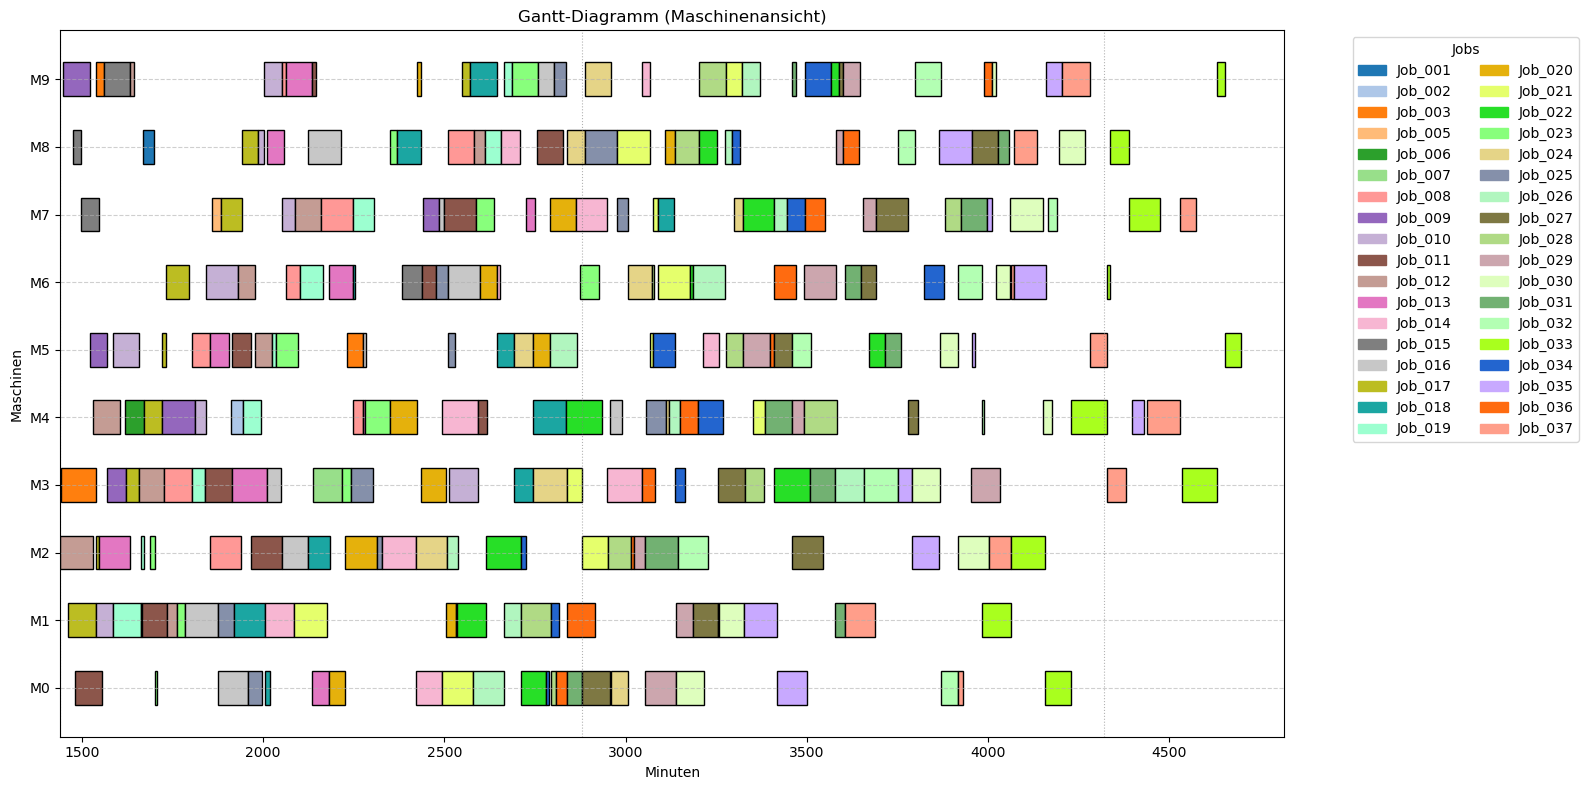

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [21]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

### Export

In [22]:
#df_plan.to_csv(main_file_path.format("0204c_lateness_sum_schedule_og.csv"), index = False)
#df_execution.to_csv(main_file_path.format("0204c_lateness_sum_schedule_simulation.csv"), index = False)
#df_reschedule.to_csv(main_file_path.format("0204c_lateness_sum_schedule_revised.csv"), index = False)

In [23]:
#df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})
#df_schedule_mix = pd.concat([df_execution, df_reschedule], ignore_index=True)
#df_schedule_mix = df_schedule_mix.sort_values(by="Start").reset_index(drop=True)
#df_schedule_mix.to_csv(main_file_path.format("0204c_lateness_sum_schedule_revised_with_sim.csv"), index = False)